In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Import our custom functions and classes from the utility script!
# The filename "pcam-data-utils.py" becomes the module name "pcam_data_utils"
import pcam_data_utils

# --- Configuration ---
# Kaggle's file system is different. Input data is in the ../input/ directory
DATA_PATH = '/kaggle/input/histopathologic-cancer-detection'
TRAIN_CSV_PATH = os.path.join(DATA_PATH, 'train_labels.csv')
TRAIN_IMAGE_DIR = os.path.join(DATA_PATH, 'train')

BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
RANDOM_STATE = 42


Utility script 'pcam_data_utils.py' loaded.


In [2]:
print("--- Loading and Splitting Data ---")
labels_df_full = pd.read_csv(TRAIN_CSV_PATH)

# Take a random sample of the full dataset. 
# Adjust 'n' to the size you want.
subset_size = 20000 
labels_df = labels_df_full.sample(n=subset_size, random_state=RANDOM_STATE)
print(f"Using a random subset of {subset_size} images for faster iteration.")

# Now split the smaller 'labels_df' instead of the full one
train_df, val_df = train_test_split(
    labels_df, # Use the subset here
    test_size=VALIDATION_SPLIT,
    random_state=RANDOM_STATE,
    stratify=labels_df['label']
)

print(f"Data split into {len(train_df)} training and {len(val_df)} validation samples.")

--- Loading and Splitting Data ---
Using a random subset of 20000 images for faster iteration.
Data split into 16000 training and 4000 validation samples.


In [3]:
# CELL 3: Create Datasets and DataLoaders using our utility script
print("\n--- Creating Datasets and DataLoaders ---")

# Get the transform functions from our utility script
transforms = pcam_data_utils.get_transforms()

# Use the PCamDataset class from our utility script
train_dataset = pcam_data_utils.PCamDataset(dataframe=train_df, image_dir=TRAIN_IMAGE_DIR, transform=transforms['train'])
val_dataset = pcam_data_utils.PCamDataset(dataframe=val_df, image_dir=TRAIN_IMAGE_DIR, transform=transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("DataLoaders created successfully!")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")


--- Creating Datasets and DataLoaders ---
DataLoaders created successfully!
Train dataset size: 16000
Validation dataset size: 4000


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [4]:
import hact_model_py

print("\n--- Initializing HACT Model ---")

# Create an instance of our custom model
model = hact_model_py.HACTModel()

# Move the model to the GPU if available (Kaggle notebooks have GPUs)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Model initialized and moved to {device}.")

# --- Sanity Check ---
# Create a random tensor with the shape of a single batch of images
# and pass it through the model to check if the output shape is correct.
dummy_batch = torch.randn(BATCH_SIZE, 3, 96, 96).to(device)
with torch.no_grad(): # We don't need to calculate gradients for this check
    output = model(dummy_batch)

print("\n--- Model Sanity Check ---")
print(f"Input shape:  {dummy_batch.shape}")
print(f"Output shape: {output.shape}")
print("Sanity check passed! The model is ready for training.")

# You can also print the model architecture to see its layers
# print(model)

Utility script 'hact_model.py' loaded.

--- Initializing HACT Model ---


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name tf_efficientnetv2_s_in21k to current tf_efficientnetv2_s.in21k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/193M [00:00<?, ?B/s]

Model initialized and moved to cuda.

--- Model Sanity Check ---
Input shape:  torch.Size([32, 3, 96, 96])
Output shape: torch.Size([32, 1])
Sanity check passed! The model is ready for training.


In [5]:
# Define Training Hyperparameters, Loss, and Optimizer

import training_utils
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

# --- Hyperparameters ---
# A lower learning rate is often better for pre-trained models.
LEARNING_RATE = 0.0001 
NUM_EPOCHS = 10 # Train for longer to see improvement

# --- Loss Function ---
criterion = nn.BCEWithLogitsLoss()

# --- Optimizer ---
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# --- NEW: Learning Rate Scheduler ---
# This will reduce the learning rate when the validation loss stops improving.
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

print("Hyperparameters, loss, optimizer, and scheduler are set.")

Utility script 'training_utils.py' loaded.
Hyperparameters, loss, optimizer, and scheduler are set.


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [6]:
print("\n--- Starting Model Training ---")

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    print("-" * 10)

    # Train for one epoch
    train_loss, train_acc = training_utils.train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

    # Validate for one epoch
    val_loss, val_metrics = training_utils.validate_one_epoch(
        model, val_loader, criterion, device
    )
    print(f"Val Loss:   {val_loss:.4f} | Val Acc: {val_metrics['accuracy']:.4f}")
    print(f"Precision: {val_metrics['precision']:.4f} | Recall: {val_metrics['recall']:.4f} | F1: {val_metrics['f1']:.4f}")

    # --- NEW: Scheduler Step ---
    # Update the learning rate based on the validation loss
    scheduler.step(val_loss)
    # --- END OF NEW CODE ---

    # Store results
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_metrics['accuracy'])

print("\n--- Training Finished ---")


--- Starting Model Training ---

Epoch 1/10
----------


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Train Loss: 0.3887 | Train Acc: 0.8327


Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Val Loss:   0.2379 | Val Acc: 0.9100
Precision: 0.9226 | Recall: 0.8483 | F1: 0.8839

Epoch 2/10
----------


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Train Loss: 0.2990 | Train Acc: 0.8792


Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Val Loss:   0.2206 | Val Acc: 0.9215
Precision: 0.9369 | Recall: 0.8638 | F1: 0.8988

Epoch 3/10
----------


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Train Loss: 0.2680 | Train Acc: 0.8964


Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Val Loss:   0.1922 | Val Acc: 0.9267
Precision: 0.9147 | Recall: 0.9028 | F1: 0.9087

Epoch 4/10
----------


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Train Loss: 0.2369 | Train Acc: 0.9069


Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Val Loss:   0.1961 | Val Acc: 0.9335
Precision: 0.9530 | Recall: 0.8786 | F1: 0.9143

Epoch 5/10
----------


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Train Loss: 0.2342 | Train Acc: 0.9104


Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Val Loss:   0.1801 | Val Acc: 0.9370
Precision: 0.9311 | Recall: 0.9115 | F1: 0.9212

Epoch 6/10
----------


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Train Loss: 0.2082 | Train Acc: 0.9229


Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Val Loss:   0.2128 | Val Acc: 0.9355
Precision: 0.9254 | Recall: 0.9139 | F1: 0.9196

Epoch 7/10
----------


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Train Loss: 0.2044 | Train Acc: 0.9244


Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Val Loss:   0.1721 | Val Acc: 0.9417
Precision: 0.9552 | Recall: 0.8978 | F1: 0.9256

Epoch 8/10
----------


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Train Loss: 0.1875 | Train Acc: 0.9294


Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Val Loss:   0.1743 | Val Acc: 0.9427
Precision: 0.9553 | Recall: 0.9003 | F1: 0.9270

Epoch 9/10
----------


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Train Loss: 0.1810 | Train Acc: 0.9341


Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Val Loss:   0.1765 | Val Acc: 0.9427
Precision: 0.9664 | Recall: 0.8892 | F1: 0.9262

Epoch 10/10
----------


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Train Loss: 0.1836 | Train Acc: 0.9342


Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Val Loss:   0.1602 | Val Acc: 0.9445
Precision: 0.9378 | Recall: 0.9238 | F1: 0.9308

--- Training Finished ---



--- Plotting Training History ---


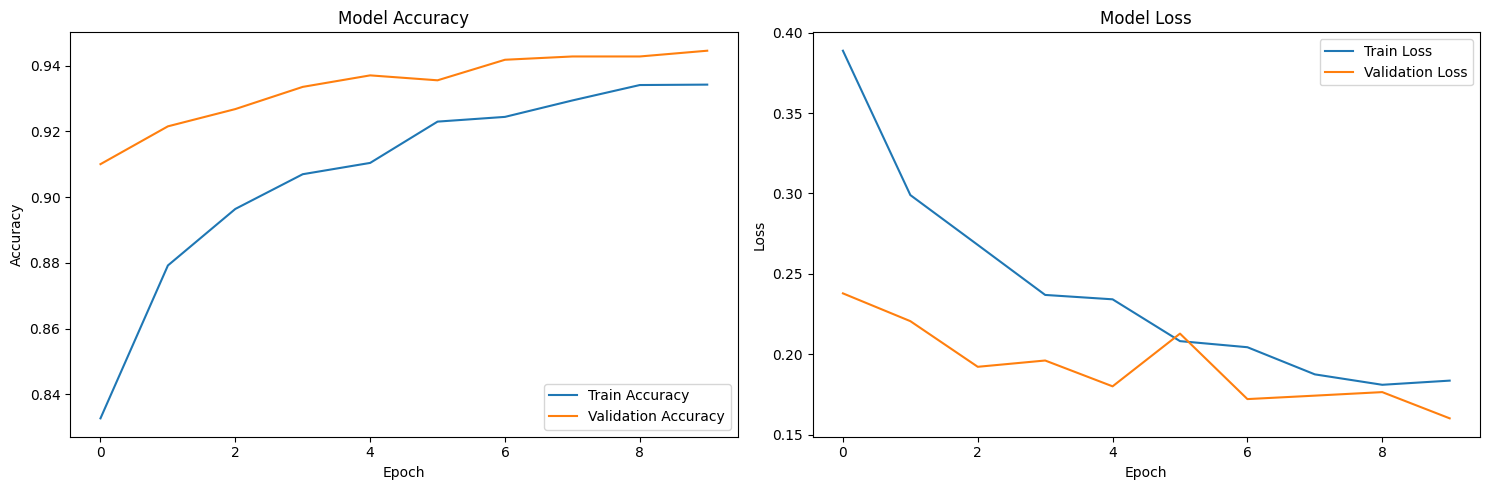

In [7]:

import matplotlib.pyplot as plt

print("\n--- Plotting Training History ---")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot training & validation accuracy values
ax1.plot(history['train_acc'], label='Train Accuracy')
ax1.plot(history['val_acc'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(loc='lower right')

# Plot training & validation loss values
ax2.plot(history['train_loss'], label='Train Loss')
ax2.plot(history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


--- Generating Confusion Matrix ---


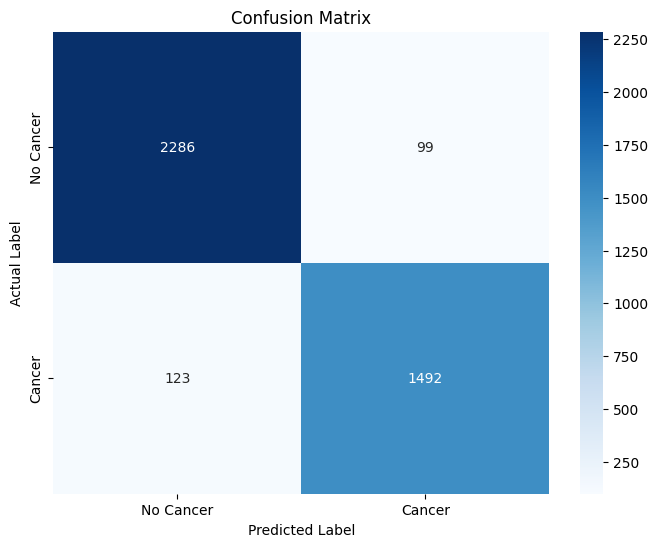

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

print("\n--- Generating Confusion Matrix ---")

# We need to get all predictions and labels from the validation set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.sigmoid(outputs).round()
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Cancer', 'Cancer'], 
            yticklabels=['No Cancer', 'Cancer'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [9]:
print("\n--- Saving Model ---")
# The state_dict contains all the learned weights and biases
model_path = 'hact_model_epoch_10.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


--- Saving Model ---
Model saved to hact_model_epoch_10.pth
